In [1]:
from google.colab import drive
import json
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.metrics import precision_recall_fscore_support, roc_curve, precision_recall_curve, auc

In [2]:
drive.mount('/content/drive', force_remount=True)
root_path = "drive/MyDrive/NNextPitch"

Mounted at /content/drive


# Tyler Glasnow

In [3]:
history_file = os.path.join(root_path, "modeling/saved-modeling-results/kfold-model-history.glasnow.pkl")
with open(history_file, 'rb') as pkl_file:
  glasnow_cv_history = pickle.load(pkl_file)

results_file = os.path.join(root_path, "modeling/saved-modeling-results/kfold-model-results.glasnow.pkl")
with open(results_file, 'rb') as pkl_file:
  glasnow_cv_results = pickle.load(pkl_file)

predictions_file = os.path.join(root_path, "modeling/saved-modeling-results/kfold-model-predictions.glasnow.pkl")
with open(predictions_file, 'rb') as pkl_file:
  glasnow_cv_predictions = pickle.load(pkl_file)

Fold: 1


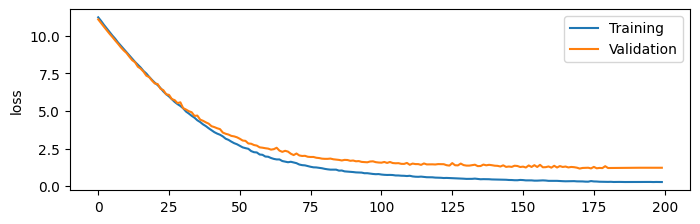

Fold: 2


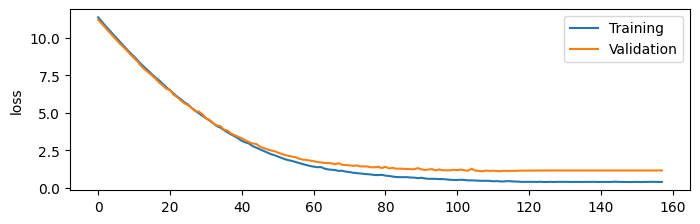

Fold: 3


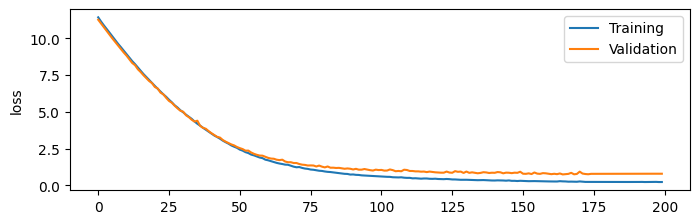

Fold: 4


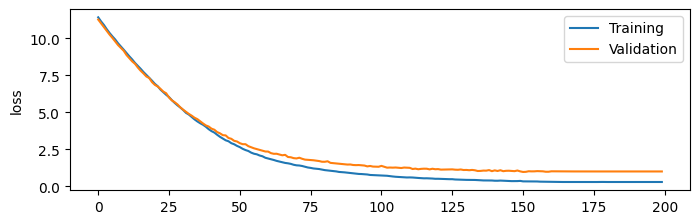

Fold: 5


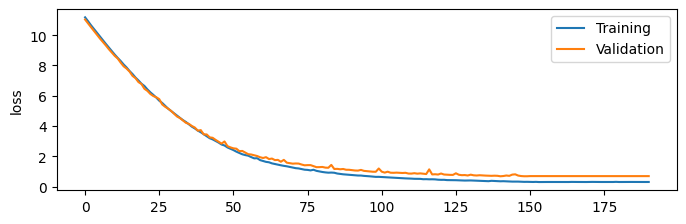

In [ ]:
# Model training/validation performances

metrics = ['loss']

for fold in range(0, 5):

  print(f"Fold: {fold+1}")
  plt.figure(figsize=(8, 8))

  for i in np.arange(len(metrics)):
      plt.subplot(3, 1, i+1)
      plt.plot(glasnow_cv_history["cnn-xtra"]["histories"][fold].history[metrics[i]], label='Training')
      plt.plot(glasnow_cv_history["cnn-xtra"]["histories"][fold].history['val_' + metrics[i]], label='Validation')

      # === Label the Chart === #
      #plt.xlabel('Epoch')
      plt.ylabel(metrics[i])
      #plt.title( metrics[i]+' During Training Model 1' )
      plt.legend()

  # === Display the Chart === #
  plt.show()


In [28]:
# Gather loss curve information in df and output file
model_map = {'cnn-xtra': 'CNN-2D', 'cnn': 'CNN-3D', 'cnn-lstm': 'CNN-3D-LSTM', 'branched-cnn': 'Branched CNN'}
loss_df = pd.DataFrame()
for key, value in model_map.items():
  model_loss_df = pd.DataFrame()
  for fold in range(0, 5):

    # Training loss
    train_loss = glasnow_cv_history[key]["histories"][fold].history['loss']
    train_loss_df = pd.DataFrame({"epoch": np.arange(1, len(train_loss)+1), f"loss": train_loss})
    train_loss_df["model"] = value
    train_loss_df["fold"] = fold
    train_loss_df["dataset"] = "training"
    model_loss_df = pd.concat([model_loss_df, train_loss_df])

    # Validation loss
    val_loss = glasnow_cv_history[key]["histories"][fold].history['val_loss']
    val_loss_df = pd.DataFrame({"epoch": np.arange(1, len(val_loss)+1), f"loss": val_loss})
    val_loss_df["model"] = value
    val_loss_df["fold"] = fold
    val_loss_df["dataset"] = "validation"
    model_loss_df = pd.concat([model_loss_df, val_loss_df])    

  loss_df = pd.concat([loss_df, model_loss_df])

# Output csv
output_file = os.path.join(root_path, "modeling/saved-modeling-results/loss-curve-data.glasnow.csv")
loss_df.to_csv(output_file, index=False)

In [ ]:
# K-fold results
## Results df per model
cnn_results_df = pd.DataFrame(glasnow_cv_results['cnn']).melt(var_name="metric")
cnn_lstm_results_df = pd.DataFrame(glasnow_cv_results['cnn-lstm']).melt(var_name="metric")
branched_cnn_results_df = pd.DataFrame(glasnow_cv_results['branched-cnn']).melt(var_name="metric")
xtra_cnn_results_df = pd.DataFrame(glasnow_cv_results['cnn-xtra']).melt(var_name="metric")

## Add model column
xtra_cnn_results_df["model"] = "CNN-2D"
cnn_results_df["model"] = "CNN-3D"
cnn_lstm_results_df["model"] = "CNN-3D-LSTM"
branched_cnn_results_df["model"] = "CNN-Branched"

## Concatenate k-fold results
kfold_results = pd.concat([
    cnn_results_df, 
    cnn_lstm_results_df, 
    branched_cnn_results_df, 
    xtra_cnn_results_df])

## Output csv
output_file = os.path.join(root_path, "modeling/saved-modeling-results/kfold-cv-metrics.glasnow.csv")
kfold_results.to_csv(output_file, index=False)

In [ ]:
# Create a table of mean CV metrics
kfold_mean_df = kfold_results.groupby(['model', 'metric']).mean().round(3)
kfold_mean_df = kfold_mean_df.reset_index()
kfold_mean_df = kfold_mean_df.pivot(index='model', columns='metric', values='value').reset_index()

# Output csv
output_file = os.path.join(root_path, "modeling/saved-modeling-results/cv-performance-table.glasnow.csv")
kfold_mean_df.to_csv(output_file, index=False)

In [ ]:
# Get fpr/tpr curve and precision/recall curve for plotting
model_map = {'cnn-xtra': 'CNN-2D', 'cnn': 'CNN-3D', 'cnn-lstm': 'CNN-3D-LSTM', 'branched-cnn': 'CNN-Branched'}
auc_df = pd.DataFrame()
auprc_df = pd.DataFrame()

for key, value in model_map.items():

  # Get all prediction scores and true labels
  y_true = np.array(list(glasnow_cv_predictions[key]['y_true'])*5)
  y_prob = np.array([glasnow_cv_predictions[key]['y_score'][str(i+1)] for i in range(0, 5)]).flatten()

  # AUC
  fpr, tpr, _ = roc_curve(y_true, y_prob)
  auc_sub_df = pd.DataFrame({
      "fpr": fpr,
      "tpr": tpr
  })
  auc_sub_df['model'] = value
  auc_df = pd.concat([auc_df, auc_sub_df])

  # AUPRC
  precision, recall, _ = precision_recall_curve(y_true, y_prob)
  auprc_sub_df = pd.DataFrame({
      "precision": precision,
      "recall": recall
  })
  auprc_sub_df['model'] = value
  auprc_df = pd.concat([auprc_df, auprc_sub_df])

# Output AUC df
output_file = os.path.join(root_path, "modeling/saved-modeling-results/auc.glasnow.csv")
auc_df.to_csv(output_file, index=False)

# Output AUPRC df
output_file = os.path.join(root_path, "modeling/saved-modeling-results/auprc.glasnow.csv")
auprc_df.to_csv(output_file, index=False)


# Walker Buehler

In [29]:
history_file = os.path.join(root_path, "modeling/saved-modeling-results/kfold-model-history.buehler.pkl")
with open(history_file, 'rb') as pkl_file:
  buehler_cv_history = pickle.load(pkl_file)

results_file = os.path.join(root_path, "modeling/saved-modeling-results/kfold-model-results.buehler.pkl")
with open(results_file, 'rb') as pkl_file:
  buehler_cv_results = pickle.load(pkl_file)

predictions_file = os.path.join(root_path, "modeling/saved-modeling-results/kfold-model-predictions.buehler.pkl")
with open(predictions_file, 'rb') as pkl_file:
  buehler_cv_predictions = pickle.load(pkl_file)

Fold: 1


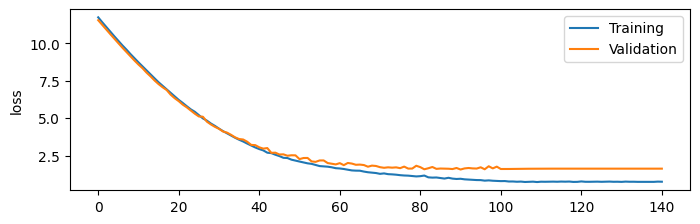

Fold: 2


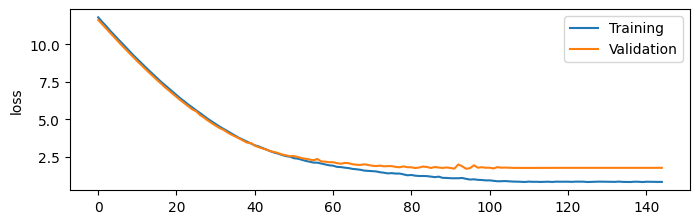

Fold: 3


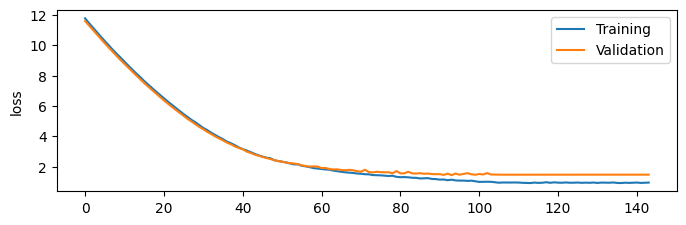

Fold: 4


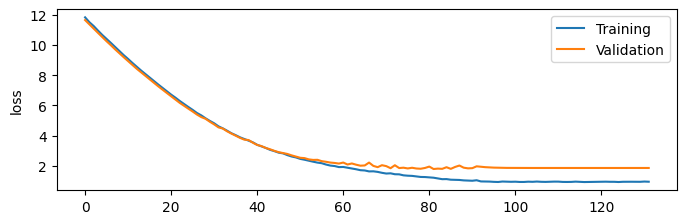

Fold: 5


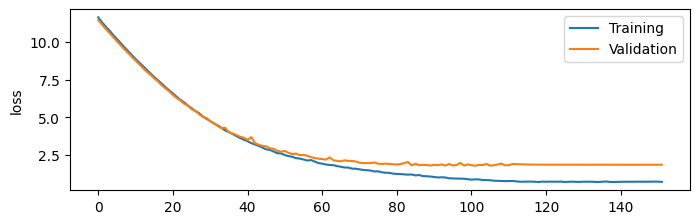

In [30]:
# Model training/validation performances

metrics = ['loss']

for fold in range(0, 5):

  print(f"Fold: {fold+1}")
  plt.figure(figsize=(8, 8))

  for i in np.arange(len(metrics)):
      plt.subplot(3, 1, i+1)
      plt.plot(buehler_cv_history["cnn-xtra"]["histories"][fold].history[metrics[i]], label='Training')
      plt.plot(buehler_cv_history["cnn-xtra"]["histories"][fold].history['val_' + metrics[i]], label='Validation')

      # === Label the Chart === #
      #plt.xlabel('Epoch')
      plt.ylabel(metrics[i])
      #plt.title( metrics[i]+' During Training Model 1' )
      plt.legend()

  # === Display the Chart === #
  plt.show()


In [31]:
# Gather loss curve information in df and output file
model_map = {'cnn-xtra': 'CNN-2D', 'cnn': 'CNN-3D', 'cnn-lstm': 'CNN-3D-LSTM', 'branched-cnn': 'Branched CNN'}
loss_df = pd.DataFrame()
for key, value in model_map.items():
  model_loss_df = pd.DataFrame()
  for fold in range(0, 5):

    # Training loss
    train_loss = buehler_cv_history[key]["histories"][fold].history['loss']
    train_loss_df = pd.DataFrame({"epoch": np.arange(1, len(train_loss)+1), f"loss": train_loss})
    train_loss_df["model"] = value
    train_loss_df["fold"] = fold
    train_loss_df["dataset"] = "training"
    model_loss_df = pd.concat([model_loss_df, train_loss_df])

    # Validation loss
    val_loss = buehler_cv_history[key]["histories"][fold].history['val_loss']
    val_loss_df = pd.DataFrame({"epoch": np.arange(1, len(val_loss)+1), f"loss": val_loss})
    val_loss_df["model"] = value
    val_loss_df["fold"] = fold
    val_loss_df["dataset"] = "validation"
    model_loss_df = pd.concat([model_loss_df, val_loss_df])    

  loss_df = pd.concat([loss_df, model_loss_df])

# Output csv
output_file = os.path.join(root_path, "modeling/saved-modeling-results/loss-curve-data.buehler.csv")
loss_df.to_csv(output_file, index=False)

In [ ]:
# K-fold results
## Results df per model
cnn_results_df = pd.DataFrame(buehler_cv_results['cnn']).melt(var_name="metric")
cnn_lstm_results_df = pd.DataFrame(buehler_cv_results['cnn-lstm']).melt(var_name="metric")
branched_cnn_results_df = pd.DataFrame(buehler_cv_results['branched-cnn']).melt(var_name="metric")
xtra_cnn_results_df = pd.DataFrame(buehler_cv_results['cnn-xtra']).melt(var_name="metric")

## Add model column
xtra_cnn_results_df["model"] = "CNN-2D"
cnn_results_df["model"] = "CNN-3D"
cnn_lstm_results_df["model"] = "CNN-3D-LSTM"
branched_cnn_results_df["model"] = "CNN-Branched"

## Concatenate k-fold results
kfold_results = pd.concat([
    cnn_results_df, 
    cnn_lstm_results_df, 
    branched_cnn_results_df, 
    xtra_cnn_results_df])

## Filter out classification_report and confusion_matrix
kfold_results = kfold_results[(kfold_results.metric != "classification_report") & (kfold_results.metric != "confusion_matrix")]
kfold_results.head()

## Output csv
output_file = os.path.join(root_path, "modeling/saved-modeling-results/kfold-cv-metrics.buehler.csv")
kfold_results.to_csv(output_file, index=False)

In [ ]:
# Create a table of mean CV metrics
kfold_mean_df = kfold_results.groupby(['model', 'metric']).mean().round(3)
kfold_mean_df = kfold_mean_df.reset_index()
kfold_mean_df = kfold_mean_df.pivot(index='model', columns='metric', values='value').reset_index()
mcc_df = kfold_mean_df[['model', 'MCC']].set_index('model')

In [ ]:
# Get OvR auc_auprc report
auc_auprc_report = pd.DataFrame()
for model in buehler_cv_results.keys():
  for classification_report in buehler_cv_results[model]['classification_report']:
    classification_report = classification_report.reset_index()
    classification_report = classification_report.melt(['index'], var_name="metric")
    classification_report = classification_report[(classification_report.metric == "auc") | (classification_report.metric == "auprc")]
    classification_report.columns = ["pitch_type", "metric", "value"]
    classification_report = classification_report[(classification_report.pitch_type != "weighted avg")]
    classification_report["model"] = model
    auc_auprc_report = pd.concat([auc_auprc_report, classification_report])
  auc_auprc_report.head(10)

# Output csv
output_file = os.path.join(root_path, "modeling/saved-modeling-results/kfold-cv-metrics-ovr.buehler.csv")
auc_auprc_report.to_csv(output_file, index=False)


In [ ]:
# Map model names to new names
model_map = {'cnn-xtra': 'CNN-2D', 'cnn': 'CNN-3D', 'cnn-lstm': 'CNN-3D-LSTM', 'branched-cnn': 'CNN-Branched'}

# Set object to store all metrics
table_results = pd.DataFrame()

# Create model-specific tables and append to full table
for key, value in model_map.items():

  # Prepare metrics
  mean_classification_report = pd.concat(buehler_cv_results[key]['classification_report'], ignore_index=False)
  mean_classification_report = mean_classification_report.reset_index()
  mean_classification_report = mean_classification_report.groupby('index').mean().round(3)
  mean_classification_report = mean_classification_report.reset_index()
  mean_classification_report.drop(columns=['pred'], inplace=True)
  mean_classification_report.columns = ['pitch_type'] + list(mean_classification_report.columns[1:-1]) + ['test_support']
  mean_classification_report.drop(columns=['pitch_type'], inplace=True)

  # Prepare confusion matrix
  conf_mats = [pd.DataFrame(conf_mat) for conf_mat in buehler_cv_results[key]['confusion_matrix']]
  confusion_mat_total = pd.concat(conf_mats, ignore_index=False)
  confusion_mat_total = confusion_mat_total.reset_index()
  confusion_mat_total = confusion_mat_total.groupby('index').sum()
  confusion_mat_total = confusion_mat_total.reset_index(drop=True)

  # Join tables, label classes and specify model type
  table_ready_df = mean_classification_report.join(confusion_mat_total)
  table_ready_df.columns = list(table_ready_df.columns[:-3]) + ["FB", "FBwM", "OFF"]
  table_ready_df = table_ready_df[list(["FB", "FBwM", "OFF"] + list(table_ready_df.columns[:-3]))]
  table_ready_df.insert(loc=0, column='model', value=value)
  table_ready_df.insert(loc=1, column='pitch_type', value=["FB", "FBwM", "OFF", "Weighted Ave."])
  table_ready_df['test_support'] = table_ready_df['test_support'].astype(int)

  # Concatenate model-specific results to full table
  table_results = pd.concat([table_results, table_ready_df])

#table_results.columns = [
#    'Model', '', 'FB', 'FBwM', 'OFF', 'Precision', 'Recall', 'F1-Score',
#    'ROC-AUC (OvR)', 'AUPRC (OvR)',	'Test Support']

table_results.set_index('model', inplace=True)
table_results = table_results.join(mcc_df)

## Output csv
output_file = os.path.join(root_path, "modeling/saved-modeling-results/cv-performance-table.buehler.csv")
table_results.to_csv(output_file, index=True)